In [1]:
# Importing the necessary stuff and setting up the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# https://www.tutorialspoint.com/how-to-read-json-file-in-python
with open('/Users/daniellecu/Downloads/transaction-data-adhoc-analysis.json') as f:
  data = json.load(f)

df = pd.DataFrame(data)
df2 = df.copy()

### Count and Sales of Each Item per Month
# Separating the items of each transaction into rows
# https://thewebdev.info/2022/03/26/how-to-split-text-in-a-column-into-multiple-rows-with-python-pandas/
df['transaction_items'] = df['transaction_items'].str.split('[;]')
df = df.explode('transaction_items').reset_index(drop=True)
cols = list(df.columns)
cols.append(cols.pop(cols.index('username')))
df = df[cols]

# Making an item count column in the dataframe by extracting the number between the parenthesis
# https://stackoverflow.com/questions/52190030/extract-all-numbers-in-brackets-with-python
def extract_count (string):
    s_filter = string[string.find("(")+2:string.find(")")]
    s_filter=int(s_filter)
    return s_filter
    
df['item count'] = df['transaction_items'].apply(extract_count)

# Cleaning up the transaction items column by only retaining the item name
# https://www.datasciencemadesimple.com/extract-last-n-characters-from-right-of-the-column-in-pandas-python/
df['transaction_items']=df['transaction_items'].str[:-5]

# Getting the list of unique items in the column
# https://www.statology.org/pandas-unique-values-in-column/#:~:text=The%20easiest%20way%20to%20obtain,use%20the%20unique()%20function.
items=df.transaction_items.unique()

# Making a column month in the dataframe
# https://www.youtube.com/watch?v=fNzUhp5uHFY&ab_channel=JieJenn
date_col = pd.DatetimeIndex(df['transaction_date'])
df['month'] = date_col.month

# Getting the count of each item per month
Jan_Count=[]
Feb_Count=[]
Mar_Count=[]
Apr_Count=[]
May_Count=[]
Jun_Count=[]
Count_List=[Jan_Count,Feb_Count,Mar_Count,Apr_Count,May_Count,Jun_Count]
k=[1,2,3,4,5,6]

# Summing up the counts of the given item (i) in the given month (k) in the data frame
for k in range (1,len(Count_List)+1):
    for i in range (len(items)):
        itemcount = df.loc[(df['month'] == k) & ((df['transaction_items'])== items[i]), ['item count']].sum()
        Count_List[k-1].append(int(itemcount))
    
# Overwriting the transaction value column by first getting the price or value of a piece of the item (new column), then multiplying it by the count of item/s bought
# https://www.journaldev.com/37898/python-numpy-where
price=[1299,1990,199,1500,500,150,799] # Prices computed manually by looking at transactions with only one kind of item and they're in order of the items array

def trans_value (item):
    tuple=np.where(items == item)
    index=tuple[0][0]
    value=(price[index])
    return value

df['value of a piece'] = df['transaction_items'].apply(trans_value)
df['transaction_value']= df['value of a piece']*df['item count']

# Getting the sales of each item per month by summing up the transactional value of the given item (i) in the given month (k) in the data frame
Jan_Sales=[]
Feb_Sales=[]
Mar_Sales=[]
Apr_Sales=[]
May_Sales=[]
Jun_Sales=[]
Sales_List=[Jan_Sales,Feb_Sales,Mar_Sales,Apr_Sales,May_Sales,Jun_Sales]
k=[1,2,3,4,5,6]

for k in range (1,len(Sales_List)+1):
    for i in range (len(items)):
        itemsales = df.loc[(df['month'] == k) & ((df['transaction_items'])== items[i]), ['transaction_value']].sum()
        Sales_List[k-1].append(int(itemsales))
    
# Constructing the table for the breakdown of items per month and their sales
breakdown = {'Items':  items,
        'January Count': Count_List[0],'January Sales': Sales_List[0],
        'February Count': Count_List[1],'February Sales': Sales_List[1],
        'March Count': Count_List[2],'March Sales': Sales_List[2],
        'April Count': Count_List[3],'April Sales': Sales_List[3],
        'May Count': Count_List[4],'May Sales': Sales_List[4],
        'June Count': Count_List[5],'June Sales': Sales_List[5],
       }

bd = pd.DataFrame(breakdown)

### Repeaters - the number of customers from the current month who also purchased in the previous month. This metric is 0 for the earliest month in the transactional data.
# Making a dataframe per each month
JanDf=df[df['month'] == 1]
FebDf=df[df['month'] == 2]
MarDf=df[df['month'] == 3]
AprDf=df[df['month'] == 4]
MayDf=df[df['month'] == 5]
JunDf=df[df['month'] == 6]

# Getting the array of unique customers per month
# 'Empty' is made in order to say there are no customers in the month before January (given the data)
Empty=()
JanCust=JanDf.username.unique()
FebCust=FebDf.username.unique()
MarCust=MarDf.username.unique()
AprCust=AprDf.username.unique()
MayCust=MayDf.username.unique()
JunCust=JunDf.username.unique()

# Setting the Repeaters variables to 0 and constructing a list for the Month Customers (aka the unique customers per month) and Repeaters per month
Jan_Repeaters=0
Feb_Repeaters=0
Mar_Repeaters=0
Apr_Repeaters=0
May_Repeaters=0
Jun_Repeaters=0

MonthCust=[Empty,JanCust,FebCust,MarCust,AprCust,MayCust,JunCust]
Repeaters=[Jan_Repeaters,Feb_Repeaters,Mar_Repeaters,Apr_Repeaters,May_Repeaters,Jun_Repeaters]

# For every month, if the customer is also a customer in the previous month, then a count will be added to the Repeaters count per month
for k in range (len(Repeaters)):
    for i in range (len(MonthCust[k+1])):
        if MonthCust[k+1][i] in MonthCust[k]:
            Repeaters[k] += 1
        else:
            Repeaters[k] += 0

### Inactive - the number of customers in the total set of transactions up to and including the current month who have purchase history but do not have a purchase for the current month. This metric is 0 for the earliest month in the transactional data.          
# Setting the Inactive variables to 0 and constructing a list for the Inactive by month
Jan_Inactive=0
Feb_Inactive=0
Mar_Inactive=0
Apr_Inactive=0
May_Inactive=0
Jun_Inactive=0

Inactive=[Jan_Inactive,Feb_Inactive,Mar_Inactive,Apr_Inactive,May_Inactive,Jun_Inactive]

# Making a list of all the customers in the data
Customers=df.username.unique()

# For every month, if the customer in the Customers array bought in that month, then it will add 0 to the count of Inactive Customers
# However, if the customer in the customer list did not buy in that month, the while loop will check the past months if the customer is in the array of customers per month (in the past months) until it reaches the first month
# If the while loop sees that the customer is in one of the past months' arrays, then it will add 1 to the count of Inactive Customers in that month and exit the loop
# After the while loop finishes checking the first month and therefore does not see that customer in the array of customers in the past months, it adds 0 to the count of Inactive Customers
for k in range (len(Inactive)):
    for i in range (len(Customers)):
        if Customers[i] not in MonthCust[k+1]:
            a=k
            while a >=0:
                if Customers[i] in MonthCust[a]:
                    Inactive[k] += 1
                    break
                else:
                    a=a-1
            Inactive[k] += 0
        else:
            Inactive[k] += 0
            
### Engaged - the number of customers in the total set of transactions up to and including the current month who have consistently purchased every single month.
# Setting the Engaged variables to 0 and constructing a list for the Engaged by month; Also rewriting the MonthCust list by removing Empty
Jan_Engaged=0
Feb_Engaged=0
Mar_Engaged=0
Apr_Engaged=0
May_Engaged=0
Jun_Engaged=0

Engaged=[Jan_Engaged,Feb_Engaged,Mar_Engaged,Apr_Engaged,May_Engaged,Jun_Engaged]
MonthCust=[JanCust,FebCust,MarCust,AprCust,MayCust,JunCust]

# For every month, if the customer in the Customers array did not buy in that month, then it will add 0 to the count of Engaged Customers.
# However, if the customer in the customer list bought in that month, then the while loop will check the past months if the customer is in the arrays of all the past months.
# If the customer is not in the array of one of the past months, the while loop breaks and therefore does not add anything to the count of Engaged Customers.
# When variable a reaches -1, it means that the customer is a customer in each of the past months; thus, it adds a count to the number of Engaged Customers for that month.
for k in range (len(Engaged)):
    for i in range (len(Customers)):
        if Customers[i] in MonthCust[k]:
            a=k
            while a >=0:
                if Customers[i] in MonthCust[a]:
                    a=a-1
                else:
                    break
            if a==-1:
                Engaged[k] += 1
        else:
            Engaged[k] += 0
            
# Making the table for the Repeaters, Inactive, and Engaged customers per month
# https://appdividend.com/2022/03/15/pandas-dataframe-transpose/
customers = {'Month':['January','February','March','April','May','June'],
             'Repeaters':Repeaters,
             'Inactive':Inactive,
             'Engaged':Engaged,
            }
cs = pd.DataFrame(data=customers)

# Transposing the index and columns
# https://www.w3resource.com/pandas/dataframe/dataframe-transpose.php
cs=cs.T

In [2]:
## Breakdown for the Count and Sales of each Item per Month
bd

,Items,January Count,January Sales,February Count,February Sales,March Count,March Sales,April Count,April Sales,May Count,May Sales,June Count,June Sales
0,"Exotic Extras,Beef Chicharon",9665,12554835,10001,12991299,9816,12750984,9890,12847110,10028,13026372,9902,12862698
1,"HealthyKid 3+,Nutrional Milk",9727,19356730,9691,19285090,9876,19653240,9786,19474140,9881,19663190,9767,19436330
2,"Candy City,Orange Beans",9774,1945026,10037,1997363,9611,1912589,9914,1972886,9964,1982836,10106,2011094
3,"HealthyKid 3+,Gummy Vitamins",9681,14521500,9980,14970000,10145,15217500,9842,14763000,9948,14922000,9980,14970000
4,"HealthyKid 3+,Yummy Vegetables",9959,4979500,10256,5128000,9896,4948000,9861,4930500,9735,4867500,9722,4861000
5,"Candy City,Gummy Worms",9559,1433850,9996,1499400,9986,1497900,10043,1506450,9801,1470150,9934,1490100
6,"Exotic Extras,Kimchi and Seaweed",9676,7731124,9949,7949251,9967,7963633,9921,7926879,9773,7808627,10104,8073096


In [3]:
## Customer Metric Data
cs

,0,1,2,3,4,5
Month,January,February,March,April,May,June
Repeaters,0,5167,5239,5191,5126,5208
Inactive,0,1416,1728,1912,1915,1840
Engaged,6583,5167,4141,3304,2685,2210


(-0.69, 5.6899999999999995, 58000000.0, 66000000.0)

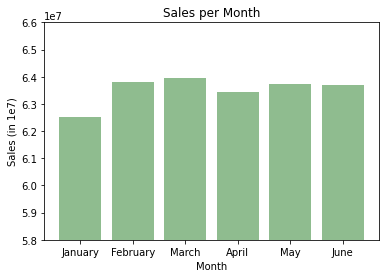

In [4]:
## Visual Data of the Sales
# Obtaining the sum of the sales per month and plotting it out in a vertical bar graph
January_Sales=sum(bd['January Sales'])
February_Sales=sum(bd['February Sales'])
March_Sales=sum(bd['March Sales'])
April_Sales=sum(bd['April Sales'])
May_Sales=sum(bd['May Sales'])
June_Sales=sum(bd['June Sales'])

Month=['January','February','March','April','May','June']
Month_Sales=[January_Sales,February_Sales,March_Sales,April_Sales,May_Sales,June_Sales]
    
plt.bar(height=Month_Sales,x=Month,color='darkseagreen')
plt.xlabel("Month")
plt.ylabel("Sales (in 1e7)")
plt.title("Sales per Month")
plt.axis([None, None, 58000000, 66000000])

(55000.0, 60000.0, -0.74, 6.739999999999999)

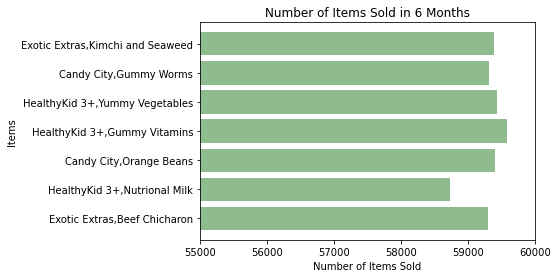

In [5]:
## Best and Least Selling Product
# Getting the sum of item counts for the whole data plotting it out in a horizontal bar graph
Item_Count=[]
for i in range (len(items)):
    count=df.loc[((df['transaction_items'])== items[i]), ['item count']].sum()
    Item_Count.append(int(count))

plt.barh (y=items,width=Item_Count,color='darkseagreen')
plt.xlabel("Number of Items Sold")
plt.ylabel("Items")
plt.title("Number of Items Sold in 6 Months")
plt.axis([55000, 60000, None, None])

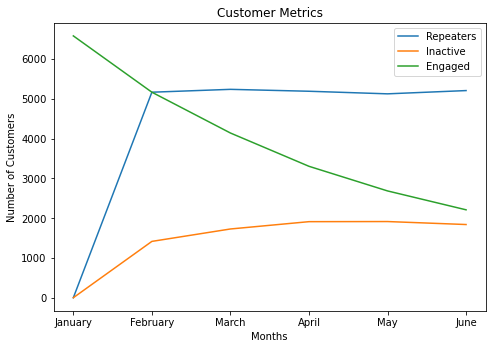

In [6]:
## Visual Data of the Customer Metrics
# Plotting out the cs (customer metrics) table in a line graph
Month=['January','February','March','April','May','June']

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.plot(Month,Repeaters,label="Repeaters")
ax.plot(Month,Inactive,label="Inactive")
ax.plot(Month,Engaged,label="Engaged")
plt.xlabel("Months")
plt.ylabel("Number of Customers")
plt.title("Customer Metrics")
ax.legend()

(400.0, 800.0, -0.9900000000000001, 11.99)

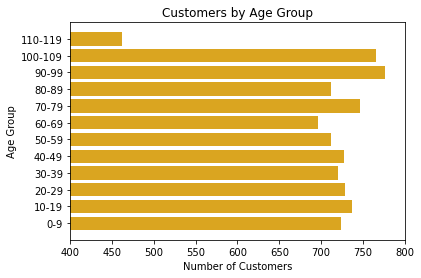

In [7]:
## Frequency of Age Groups of the (Unique) Customers by intervals of 10
# Making the age column
# https://www.geeksforgeeks.org/convert-birth-date-to-age-in-pandas/
from datetime import datetime
from datetime import date

def calculate_age(born):
    born = datetime.strptime(born, "%Y/%m/%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df2['age'] = df2['birthdate'].apply(calculate_age)

# Making the Age Group by intervals of 10
def age_group(age):
     if age >= 110:
        return "12"
     elif age >= 100:
        return "11"
     elif age >= 90:
        return "10"
     elif age >= 80:
        return "9"
     elif age >= 70:
        return "8"
     elif age >= 60:
        return "7"
     elif age >= 50:
        return "6"
     elif age >= 40:
        return "5"
     elif age >= 30:
        return "4"
     elif age >= 20:
        return "3"
     elif age >= 10:
        return "2"
     else:
        return "1"

# Adding an "age group" column
df2['age'].apply(age_group)
df2['age group']=df2['age'].apply(age_group)

# Removing duplicate rows with the same username in df2
# https://towardsdatascience.com/finding-and-removing-duplicate-rows-in-pandas-dataframe-c6117668631f
df2=df2.drop_duplicates(subset=['username'])
Group1=0
Group2=0
Group3=0
Group4=0
Group5=0
Group6=0
Group7=0
Group8=0
Group9=0
Group10=0
Group11=0
Group12=0

AgeGroupData=[Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9,Group10,Group11,Group12]

# Getting the number of customers within the same age group
for i in range (len(AgeGroupData)):
    v=df2['age group']==str(i+1)
    AgeGroupData[i]=len(df2.loc[v,:])

# Making the Horizontal Bar Graph
AgeGroup=['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119']
plt.barh (y=AgeGroup,width=AgeGroupData,color='goldenrod')
plt.xlabel("Number of Customers")
plt.ylabel("Age Group")
plt.title("Customers by Age Group")
plt.axis([400, 800, None, None])

<function matplotlib.pyplot.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)>

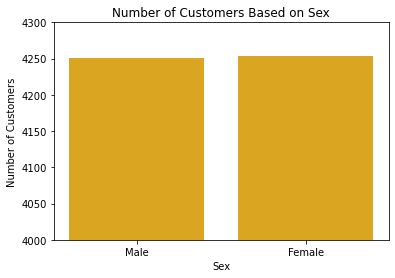

In [8]:
## Sex of Customers Data
# Getting the number of F and M for the sex of the unique customers and plotting it out in a vertical bar graph
FCount=len(df2[df2['sex'].str.contains("F")])
MCount=len(df2[df2['sex'].str.contains("M")])

MF=[MCount,FCount]
Sex=['Male','Female']

plt.bar(height=MF,x=Sex,color='goldenrod')
plt.xlabel("Sex")
plt.ylabel("Number of Customers")
plt.title("Number of Customers Based on Sex")
plt.axis([None, None, 4000, 4300])
plt.bar

<AxesSubplot:ylabel='Location'>

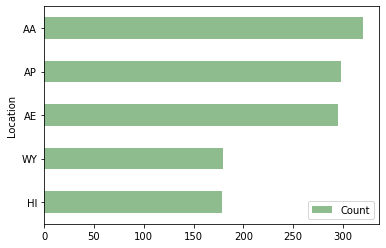

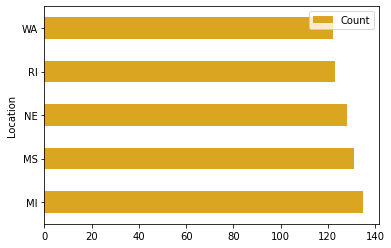

In [9]:
## Location Data
# https://www.geeksforgeeks.org/pandas-groupby-count-occurrences-in-column/
# https://realpython.com/pandas-sort-python/#:~:text=start%20from%20zero.-,Sorting%20Your%20DataFrame%20on%20a%20Single%20Column,DataFrame%20sorted%20in%20ascending%20order.
# https://statisticsglobe.com/extract-top-bottom-n-rows-from-pandas-dataframe-in-python
# Obtaining the two-letter location code of the address of each customer 
df2['Location'] = df2['address'].str[-8:-6]

# Getting an array of the unique locations and getting and making a datafram for the count of of each location
locations=df2.Location.unique()
occur = df2.groupby(['Location']).size()
locs= {'Count':occur}
lc = pd.DataFrame(data=locs)

# Sorting the dataframe in descending order and only getting the first 5
lc=lc.sort_values('Count',ascending=False)
top5=lc.head(5)

# Sorting the dataframe in ascending order and only getting the first 5
top5=top5.sort_values("Count",ascending=True)
bottom5=lc.tail(5)

# Plotting both dataframes
top5.plot.barh(color='darkseagreen')
bottom5.plot.barh(color='goldenrod')